# XGBoost model for SET50 Time-Series Price Prediction

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

1. Load the data  
2. Data preprocessing  
3. Fit regression mode  
4. Plot training deviance  
5. Plot feature importance  


## Features - Technical Indicators


ADOSC   Accumulation/Distribution oscillator

ADOSC - Chaikin A/D Oscillator  
real = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)  
https://mrjbq7.github.io/ta-lib/func_groups/volume_indicators.html

In [ ]:
# Uncomment and run if TA-lib not already installed
# !pip install talib-binary

# !pip install scikit-learn==0.23
#import sklearn
#sklearn.__version__

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os, os.path

from talib.abstract import *


from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
DATA_HOME = os.path.join("..", "..", "historical")
s = "SET50"
df = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)
df.index = pd.to_datetime(df.index) # Convert index column to datetime
df.sort_index(inplace=True)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,833.29,878.09,878.80,833.29,1.15B,-5.67%
2014-01-03,829.89,822.27,837.38,816.50,1.32B,-0.41%
2014-01-06,837.68,829.46,838.87,815.56,1.21B,0.94%
2014-01-07,861.63,842.15,861.71,840.12,1.13B,2.86%
2014-01-08,859.35,861.40,871.47,854.50,1.15B,-0.26%
...,...,...,...,...,...,...
2020-11-18,888.51,872.85,888.51,868.84,1.94B,1.35%
2020-11-19,889.70,886.73,895.15,885.50,2.13B,0.13%
2020-11-20,904.47,888.78,905.30,886.94,3.00B,1.66%


In [3]:
def to_float(x):
    if isinstance(x, str):
        x = x.replace(',','')
        if 'K' in x:
            p1, p2 = x.split('K')
            return float(p1) * 1000
        if 'M' in x:
            p1, p2 = x.split('M')
            return float(p1) * 1000000
        if 'B' in x:
            p1, p2 = x.split('B')
            return float(p1) * 1000000000
    return float(x) # already float!

df['Open'] = df['Open'].apply(to_float)
df['High'] = df['High'].apply(to_float)
df['Low'] = df['Low'].apply(to_float)
df['Price'] = df['Price'].apply(to_float)
df['Vol.'] = df['Vol.'].apply(to_float)

daily = df
inputs = {
    'open': daily.loc[:,"Open"],
    'high': daily.loc[:,"High"],
    'low': daily.loc[:,"Low"],
    'close': daily.loc[:,"Price"],
    'volume': daily.loc[:,"Vol."]
}

daily.loc[:,("SMA")] = SMA(inputs, timeperiod=25).tolist()
daily.loc[:,("WMA")] = WMA(inputs).tolist()
daily.loc[:,("ADOSC")] = ADOSC(inputs, fastperiod=3, slowperiod=10).tolist()
daily.loc[:,("ATR")] = ATR(inputs).tolist()
daily.loc[:,("RSI")] = RSI(inputs).tolist()

daily

,Price,Open,High,Low,Vol.,Change %,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2014-01-02,833.29,878.09,878.80,833.29,1.150000e+09,-5.67%,NaN,NaN,NaN,NaN,NaN
2014-01-03,829.89,822.27,837.38,816.50,1.320000e+09,-0.41%,NaN,NaN,NaN,NaN,NaN
2014-01-06,837.68,829.46,838.87,815.56,1.210000e+09,0.94%,NaN,NaN,NaN,NaN,NaN
2014-01-07,861.63,842.15,861.71,840.12,1.130000e+09,2.86%,NaN,NaN,NaN,NaN,NaN
2014-01-08,859.35,861.40,871.47,854.50,1.150000e+09,-0.26%,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,888.51,872.85,888.51,868.84,1.940000e+09,1.35%,800.4888,815.972731,9.674807e+08,18.416850,76.046737
2020-11-19,889.70,886.73,895.15,885.50,2.130000e+09,0.13%,804.2844,821.743462,8.335205e+08,17.790647,76.265885
2020-11-20,904.47,888.78,905.30,886.94,3.000000e+09,1.66%,809.1824,828.247570,1.571185e+09,17.831315,78.852070


In [5]:
# Develop convert script

p1, p2 = '3.65M'.split('M')
float(p1) * 1000000

daily[['Price']].values

array([[833.29],
       [829.89],
       [837.68],
       ...,
       [904.47],
       [927.63],
       [912.85]])

# Dataset for 1-day-ahead

In [6]:
data = daily
# Target: Tomorrow's closing price
data.loc[:,("Tomorrow")] = data["Price"].shift(-1)
# data.dropna(inplace=True)

# Target: Future time
data.loc[:,("1-day-ahead")] = data["Price"].shift(-1)
data.loc[:,("3-day-ahead")] = data["Price"].shift(-3)
data.loc[:,("5-day-ahead")] = data["Price"].shift(-5)
data.loc[:,("10-day-ahead")] = data["Price"].shift(-10)
data.loc[:,("15-day-ahead")] = data["Price"].shift(-15)
data.loc[:,("30-day-ahead")] = data["Price"].shift(-30)


# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

In [7]:
data

,Price,Open,High,Low,Vol.,Change %,SMA,WMA,ADOSC,ATR,RSI,Tomorrow,1-day-ahead,3-day-ahead,5-day-ahead,10-day-ahead,15-day-ahead,30-day-ahead
Date,,,,,,,,,,,,,,,,,,
2014-01-02,833.29,878.09,878.80,833.29,1.150000e+09,-5.67%,NaN,NaN,NaN,NaN,NaN,829.89,829.89,861.63,860.00,888.02,894.11,890.01
2014-01-03,829.89,822.27,837.38,816.50,1.320000e+09,-0.41%,NaN,NaN,NaN,NaN,NaN,837.68,837.68,859.35,858.25,883.94,898.88,906.24
2014-01-06,837.68,829.46,838.87,815.56,1.210000e+09,0.94%,NaN,NaN,NaN,NaN,NaN,861.63,861.63,860.00,880.70,879.05,878.55,901.09
2014-01-07,861.63,842.15,861.71,840.12,1.130000e+09,2.86%,NaN,NaN,NaN,NaN,NaN,859.35,859.35,858.25,887.93,880.84,865.18,896.85
2014-01-08,859.35,861.40,871.47,854.50,1.150000e+09,-0.26%,NaN,NaN,NaN,NaN,NaN,860.00,860.00,880.70,871.02,879.59,863.61,883.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,888.51,872.85,888.51,868.84,1.940000e+09,1.35%,800.4888,815.972731,9.674807e+08,18.416850,76.046737,889.70,889.70,927.63,NaN,NaN,NaN,NaN
2020-11-19,889.70,886.73,895.15,885.50,2.130000e+09,0.13%,804.2844,821.743462,8.335205e+08,17.790647,76.265885,904.47,904.47,912.85,NaN,NaN,NaN,NaN
2020-11-20,904.47,888.78,905.30,886.94,3.000000e+09,1.66%,809.1824,828.247570,1.571185e+09,17.831315,78.852070,927.63,927.63,NaN,NaN,NaN,NaN,NaN


# Initial Setup XGBoost.

Run with 5 TI: SMA	WMA	ADOSC	ATR	RSI

In [8]:
df = data[['SMA','WMA','ADOSC','ATR','RSI','1-day-ahead']]
df

,SMA,WMA,ADOSC,ATR,RSI,1-day-ahead
Date,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,829.89
2014-01-03,NaN,NaN,NaN,NaN,NaN,837.68
2014-01-06,NaN,NaN,NaN,NaN,NaN,861.63
2014-01-07,NaN,NaN,NaN,NaN,NaN,859.35
2014-01-08,NaN,NaN,NaN,NaN,NaN,860.00
...,...,...,...,...,...,...
2020-11-18,800.4888,815.972731,9.674807e+08,18.416850,76.046737,889.70
2020-11-19,804.2844,821.743462,8.335205e+08,17.790647,76.265885,904.47
2020-11-20,809.1824,828.247570,1.571185e+09,17.831315,78.852070,927.63


In [9]:
df.dropna(inplace=True)

features = df[['SMA','WMA','ADOSC','ATR','RSI']]
target = df[['1-day-ahead']]

X = features.values  # .values so becomes numpy array to feed to model. Ex. diabetes = datasets.load_diabetes()
y = target.values    # Check that dimension and type same as example dataset: diabetes.data, diabetes.target


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

### Fit Regressor

In [11]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The mean squared error (MSE) on test set: 104.2956


In [12]:
mse = mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))

The mean squared error (MSE) on train set: 59.8860


## Plot boosting iteration

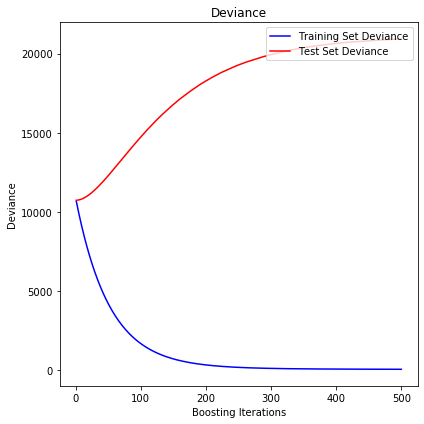

In [13]:
# Fixed error:
# This line throws exception:
# test_score[i] = reg.loss_(y_test, y_pred)
# y_test is string. hmm... So the price column turns out to be string, not float.


test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Plot feature importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

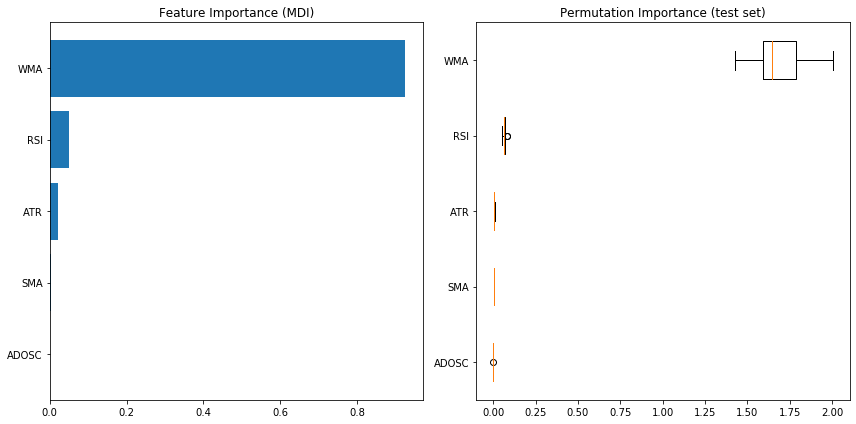

In [14]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(features.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Making Prediction

In [20]:
df['2019-03-20':'2019-03-21']

,SMA,WMA,ADOSC,ATR,RSI,1-day-ahead
Date,,,,,,
2019-03-20,1091.2924,1088.575032,-8.495468e+08,10.283319,46.183938,1087.41
2019-03-21,1090.6684,1088.242602,-9.299975e+08,10.294510,50.186142,1098.85


In [21]:
today = df['2019-03-20':'2019-03-20'][['SMA','WMA','ADOSC','ATR','RSI']]
input_vec = today.values
input_vec

array([[ 1.09129240e+03,  1.08857503e+03, -8.49546793e+08,
         1.02833189e+01,  4.61839377e+01]])

In [27]:
pred = reg.predict(input_vec)[0] # Prediction
pred

1081.4691294388751

In [29]:
# Compare pred vs actual
actual = df['2019-03-20':'2019-03-20']['1-day-ahead'].values[0]
actual

1087.41

In [31]:
print("Prediction = %0.2f ; Actual = %s" % (pred, actual))

Prediction = 1081.47 ; Actual = 1087.41


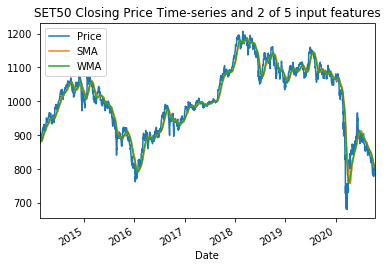

In [55]:
# Using fitted model to predict full time-series. Since this is "non-linear" and no re-train, expect high-variance in prediction

pred_res = [] # For storing output
data[['Price','SMA','WMA']].plot(title="SET50 Closing Price Time-series and 2 of 5 input features")

In [56]:
data.dropna(inplace=True) # Remove NA row

# Use iterrows to iterrate the dataframe
# https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/

for idx, r in data[['SMA','WMA','ADOSC','ATR','RSI','1-day-ahead']].iterrows():
    # print(idx, r)
    # print(r.values)
    input_vec = [r[['SMA','WMA','ADOSC','ATR','RSI']].values]
    pred = reg.predict(input_vec)[0]
    actual = r['1-day-ahead']
    print("%s Prediction = %0.2f ; Actual = %s" % (idx, pred, actual))
    item = {'Date':idx, 'Predict': pred, 'Actual': actual}
    pred_res.append(item)

data

2014-02-12 00:00:00 Prediction = 898.08 ; Actual = 890.01
2014-02-13 00:00:00 Prediction = 903.70 ; Actual = 906.24
2014-02-17 00:00:00 Prediction = 908.31 ; Actual = 901.09
2014-02-18 00:00:00 Prediction = 906.08 ; Actual = 896.85
2014-02-19 00:00:00 Prediction = 899.63 ; Actual = 883.3
2014-02-20 00:00:00 Prediction = 892.48 ; Actual = 883.06
2014-02-21 00:00:00 Prediction = 892.01 ; Actual = 881.56
2014-02-24 00:00:00 Prediction = 891.91 ; Actual = 883.16
2014-02-25 00:00:00 Prediction = 892.01 ; Actual = 883.56
2014-02-26 00:00:00 Prediction = 892.43 ; Actual = 894.16
2014-02-27 00:00:00 Prediction = 899.58 ; Actual = 899.51
2014-02-28 00:00:00 Prediction = 904.02 ; Actual = 909.96
2014-03-03 00:00:00 Prediction = 912.10 ; Actual = 913.94
2014-03-04 00:00:00 Prediction = 912.34 ; Actual = 917.59
2014-03-05 00:00:00 Prediction = 912.21 ; Actual = 916.04
2014-03-06 00:00:00 Prediction = 912.34 ; Actual = 916.97
2014-03-07 00:00:00 Prediction = 915.93 ; Actual = 912.28
2014-03-10 00:0

2016-01-25 00:00:00 Prediction = 800.74 ; Actual = 794.42
2016-01-26 00:00:00 Prediction = 800.66 ; Actual = 802.65
2016-01-27 00:00:00 Prediction = 813.92 ; Actual = 813.29
2016-01-28 00:00:00 Prediction = 825.90 ; Actual = 826.21
2016-01-29 00:00:00 Prediction = 829.63 ; Actual = 821.82
2016-02-01 00:00:00 Prediction = 829.63 ; Actual = 810.85
2016-02-02 00:00:00 Prediction = 819.10 ; Actual = 816.62
2016-02-03 00:00:00 Prediction = 825.26 ; Actual = 821.3
2016-02-04 00:00:00 Prediction = 829.17 ; Actual = 828.28
2016-02-05 00:00:00 Prediction = 828.92 ; Actual = 825.48
2016-02-08 00:00:00 Prediction = 828.92 ; Actual = 821.52
2016-02-09 00:00:00 Prediction = 825.09 ; Actual = 822.04
2016-02-10 00:00:00 Prediction = 825.70 ; Actual = 804.55
2016-02-11 00:00:00 Prediction = 803.27 ; Actual = 804.38
2016-02-12 00:00:00 Prediction = 803.81 ; Actual = 812.74
2016-02-15 00:00:00 Prediction = 819.70 ; Actual = 814.1
2016-02-16 00:00:00 Prediction = 819.70 ; Actual = 814.71
2016-02-17 00:00

2016-10-07 00:00:00 Prediction = 949.48 ; Actual = 927.87
2016-10-10 00:00:00 Prediction = 928.67 ; Actual = 917.14
2016-10-11 00:00:00 Prediction = 926.66 ; Actual = 896.3
2016-10-12 00:00:00 Prediction = 900.28 ; Actual = 906.77
2016-10-13 00:00:00 Prediction = 923.13 ; Actual = 943.85
2016-10-14 00:00:00 Prediction = 941.68 ; Actual = 939.76
2016-10-17 00:00:00 Prediction = 941.68 ; Actual = 937.67
2016-10-18 00:00:00 Prediction = 934.32 ; Actual = 940.21
2016-10-19 00:00:00 Prediction = 941.88 ; Actual = 944.52
2016-10-20 00:00:00 Prediction = 941.88 ; Actual = 947.01
2016-10-21 00:00:00 Prediction = 942.43 ; Actual = 949.16
2016-10-25 00:00:00 Prediction = 942.83 ; Actual = 938.42
2016-10-26 00:00:00 Prediction = 934.60 ; Actual = 941.27
2016-10-27 00:00:00 Prediction = 942.07 ; Actual = 938.72
2016-10-28 00:00:00 Prediction = 934.36 ; Actual = 936.66
2016-10-31 00:00:00 Prediction = 934.52 ; Actual = 942.56
2016-11-01 00:00:00 Prediction = 941.79 ; Actual = 937.75
2016-11-02 00:0

2018-01-25 00:00:00 Prediction = 1185.22 ; Actual = 1189.45
2018-01-26 00:00:00 Prediction = 1189.86 ; Actual = 1195.46
2018-01-29 00:00:00 Prediction = 1191.81 ; Actual = 1186.17
2018-01-30 00:00:00 Prediction = 1184.44 ; Actual = 1186.16
2018-01-31 00:00:00 Prediction = 1185.98 ; Actual = 1191.83
2018-02-01 00:00:00 Prediction = 1187.44 ; Actual = 1188.12
2018-02-02 00:00:00 Prediction = 1183.47 ; Actual = 1175.46
2018-02-05 00:00:00 Prediction = 1171.30 ; Actual = 1161.67
2018-02-06 00:00:00 Prediction = 1163.18 ; Actual = 1159.01
2018-02-07 00:00:00 Prediction = 1157.47 ; Actual = 1156.96
2018-02-08 00:00:00 Prediction = 1157.06 ; Actual = 1154.71
2018-02-09 00:00:00 Prediction = 1155.94 ; Actual = 1163.81
2018-02-12 00:00:00 Prediction = 1165.16 ; Actual = 1164.95
2018-02-13 00:00:00 Prediction = 1164.97 ; Actual = 1160.09
2018-02-14 00:00:00 Prediction = 1164.71 ; Actual = 1168.97
2018-02-15 00:00:00 Prediction = 1172.99 ; Actual = 1171.83
2018-02-16 00:00:00 Prediction = 1172.34

2018-12-04 00:00:00 Prediction = 1109.62 ; Actual = 1103.85
2018-12-06 00:00:00 Prediction = 1098.70 ; Actual = 1099.57
2018-12-07 00:00:00 Prediction = 1092.01 ; Actual = 1086.83
2018-12-11 00:00:00 Prediction = 1083.17 ; Actual = 1089.2
2018-12-12 00:00:00 Prediction = 1083.35 ; Actual = 1074.2
2018-12-13 00:00:00 Prediction = 1078.25 ; Actual = 1071.65
2018-12-14 00:00:00 Prediction = 1073.34 ; Actual = 1068.52
2018-12-17 00:00:00 Prediction = 1072.66 ; Actual = 1055.76
2018-12-18 00:00:00 Prediction = 1067.76 ; Actual = 1068.47
2018-12-19 00:00:00 Prediction = 1075.58 ; Actual = 1066.22
2018-12-20 00:00:00 Prediction = 1068.57 ; Actual = 1067.01
2018-12-21 00:00:00 Prediction = 1069.26 ; Actual = 1064.26
2018-12-24 00:00:00 Prediction = 1061.32 ; Actual = 1040.06
2018-12-25 00:00:00 Prediction = 1047.92 ; Actual = 1040.71
2018-12-26 00:00:00 Prediction = 1047.92 ; Actual = 1033.81
2018-12-27 00:00:00 Prediction = 1042.55 ; Actual = 1044.92
2018-12-28 00:00:00 Prediction = 1042.85 ;

,Price,Open,High,Low,Vol.,Change %,SMA,WMA,ADOSC,ATR,RSI,Tomorrow,1-day-ahead,3-day-ahead,5-day-ahead,10-day-ahead,15-day-ahead,30-day-ahead
Date,,,,,,,,,,,,,,,,,,
2014-02-12,892.57,881.34,892.85,880.19,8.839100e+08,1.53%,876.4028,875.703462,1.560123e+08,14.745799,63.437291,890.01,890.01,901.09,883.30,894.16,916.04,919.06
2014-02-13,890.01,892.36,894.52,887.44,9.085800e+08,-0.29%,877.6032,876.925806,1.732726e+08,14.198242,61.983038,906.24,906.24,896.85,883.06,899.51,916.97,929.84
2014-02-17,906.24,895.41,906.82,893.10,1.150000e+09,1.82%,879.5228,879.073269,4.995538e+08,14.384796,67.128027,901.09,901.09,883.30,881.56,909.96,912.28,935.76
2014-02-18,901.09,902.20,904.07,893.05,1.050000e+09,-0.57%,880.3384,880.724280,7.410213e+08,14.299454,64.160804,896.85,896.85,883.06,883.16,913.94,923.94,943.93
2014-02-19,896.85,905.33,906.32,894.73,8.845200e+08,-0.47%,880.6952,881.965376,5.939590e+08,14.105921,61.741090,883.30,883.30,881.56,883.56,917.59,917.68,950.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-05,781.81,783.52,785.56,778.07,8.629300e+08,0.58%,816.3876,809.064086,-7.420078e+08,12.861761,33.684721,787.62,787.62,804.96,804.59,760.71,756.02,888.51
2020-10-06,787.62,788.32,792.25,785.10,1.370000e+09,0.74%,813.6808,806.821849,-7.689918e+08,12.688778,37.335482,797.43,797.43,800.79,794.81,765.10,751.14,889.70
2020-10-07,797.43,785.08,798.08,782.21,1.360000e+09,1.25%,811.8092,805.325312,-3.128422e+08,12.916009,43.037594,804.96,804.96,804.59,782.02,762.68,746.26,904.47


In [61]:
res = pd.DataFrame(pred_res)
res = res.set_index('Date')
res.index = pd.to_datetime(res.index) # Convert index column to datetime
res.sort_index(inplace=True)
res

,Predict,Actual
Date,,
2014-02-12,898.082752,890.01
2014-02-13,903.700156,906.24
2014-02-17,908.306130,901.09
2014-02-18,906.078559,896.85
2014-02-19,899.626251,883.30
...,...,...
2020-10-05,785.837852,787.62
2020-10-06,792.814835,797.43
2020-10-07,798.193884,804.96


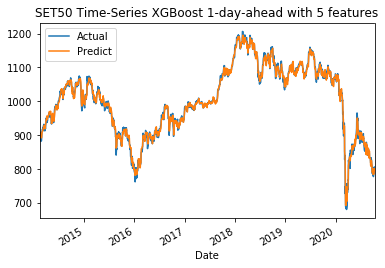

In [62]:
res[['Actual', 'Predict']].plot(title="SET50 Time-Series XGBoost 1-day-ahead with 5 features")

In [65]:
mse = mean_squared_error(res[['Actual']].values,res[['Predict']].values)
print("MSE %s" % mse)

MSE 63.660690147415906


# TODO: Add more features and perform feature selection experiment

#### [Mosavi2020] Deep learning for Stock Market Prediction  

10 indicators

Simple n-day moving average = 𝐶𝑡+𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1 / n  
Weighted 14-day moving average = 𝑛∗𝐶𝑡+(𝑛−1)∗𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1 𝑛+(𝑛−1)+⋯+1  
Momentum = 𝐶𝑡 − 𝐶𝑡−𝑛+1  
Stochastic K% = 𝐶𝑡−𝐿𝐿𝑡__𝑡−𝑛+1 *100  
Stochastic D% = 𝐾𝑡+𝐾𝑡−1+⋯+𝐾𝑡−𝑛+1*100  
Relative strength index (RSI) 
Signal(n)t ~ MACD
Larry William’s R%   
Accumulation/Distribution (A/D) oscillator  
CCI (Commodity channel index)  


#### [Shynkevich2017] Forecasting price movements using technical indicators: Investigating the impact of varying input window length

Shynkevich, Yauheniya, McGinnity, T. M., Coleman, Sonya A., Belatreche, Ammar and Li, Yuhua (2017) Forecasting price movements using technical indicators: Investigating the impact of varying input window length. Neurocomputing, 264. pp. 71-88. ISSN 0925-2312

10 indicators

Simple Moving Average (SMA)  
Exponential Moving Average (EMA)  
Average True Range (ATR)  
Average Directional Movement Index (ADMI)  
Commodity Channel Index (CCI)  
Price rate-of-change (ROC)  
Relative Strength Index (RSI)  
William’s %R oscillator  
Stochastic %K  
Stochastic %D  

#### [Parray2020] Time series data analysis of stock price movement using machine learning techniques

Exponential moving average (EMA)  12,26  
Moving average convergence divergence (MACD)  
Relative strength index (RSI)  
Average true range (ATR)  
